# 作业四：层次聚类

## 总体要求
- dataset/01-True/country.csv 是摘自《世界竞争力报告--1997》关于 20 数国家和地区个信息基础设施发展状况数据，根据该数据对这些国家和地区进行分层聚类分析，比较不同距离定义下的聚类结果。

## 实验说明

### a. 数据集说明
数据集包含以下特征：
1. **Call** — 每千人拥有电话线数
2. **movecall** — 每千房居民蜂窝移动电话数
3. **fee** — 高峰时期每三分钟国际电话个成本
4. **Computer** — 每千人拥有个计算机数
5. **mips** — 每千人计算机功率（每秒百万指令）
6. **net** — 每千人互联网户主数

### b. 聚类分组说明
结合实际，可以选择将 20 个国家分为两类：
- 第一类：巴西、智利、墨西哥、俄罗斯、波兰、匈牙利、马来西亚、泰国、印度等国家，基本上都是当时的转型国家和亚洲、拉美的发展中国家，信息基础设施较为落后。
- 第二类：其它 11 个国家和地区，包括美国、日本、欧洲发达国家以及新兴工业化国家和地区。

### c. 任务要求
1. 手动实现分层聚类。
2. 比较不同距离定义下的聚类结果。
3. Notebook 需要包含关键代码、注释和结果分析内容。


## 1. 读取数据并预处理

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Step 1: 读取数据并预处理
file_path = '/home/aistudio/dataset/01-True/country_translate_english.csv'  
data = pd.read_csv(file_path)

+ 读取数据：从指定的文件路径读取 CSV 文件，将数据加载到` data DataFrame` 中。
+ `scipy`用于层次聚类

## 2. 处理缺失值

In [8]:
# Step 2: 处理缺失值
# 用 'net' 列的中位数填充缺失值
data['net'] = data['net'].fillna(data['net'].median())

**处理缺失值**：检查 `data` 中 `net` 列的缺失值，用该列的中位数填充缺失值。`fillna()` 是用于填充缺失数据的方法。

## 3. 选择数值列并标准化数据

In [9]:
# Step 3: 选择数值列并标准化数据
data_values = data.iloc[:, 2:].values  # 选择数值列进行聚类
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_values)

- **选择数值列**：通过 `iloc` 方法选择数据的数值部分（从第3列开始），并提取这些值作为聚类输入数据。
- **标准化数据**：使用 `StandardScaler` 对数据进行标准化，使其具有均值0和方差1

## 4. 执行分层聚类（选择不同的链接方法与距离度量）

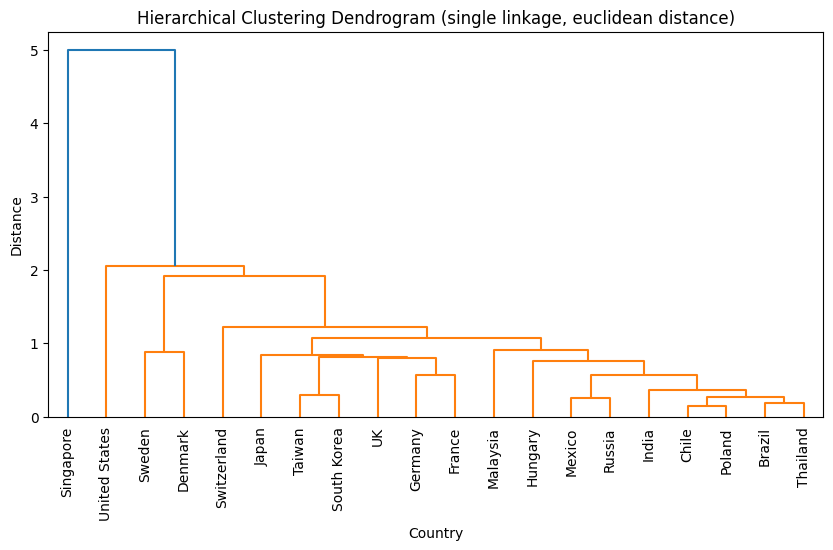

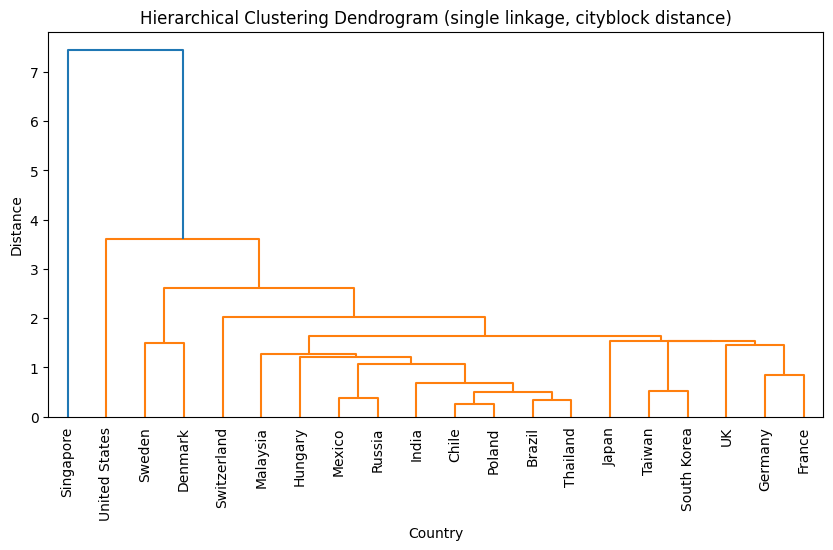

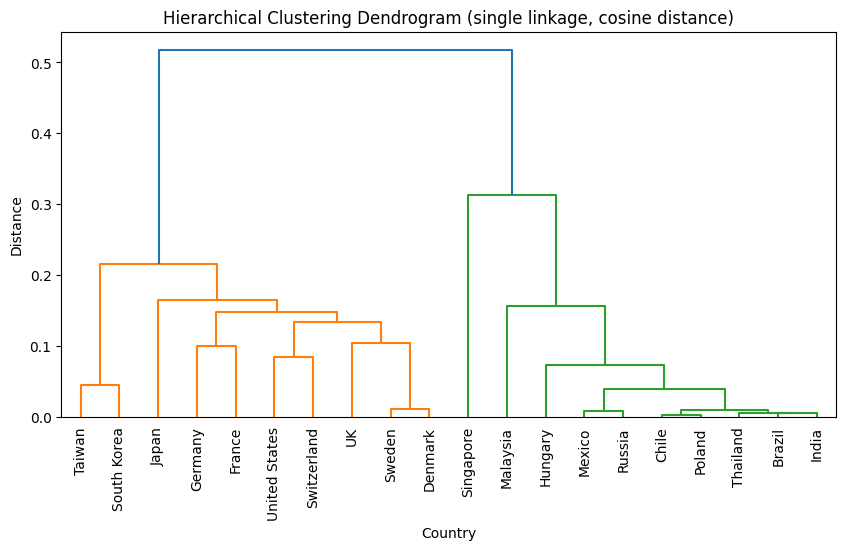

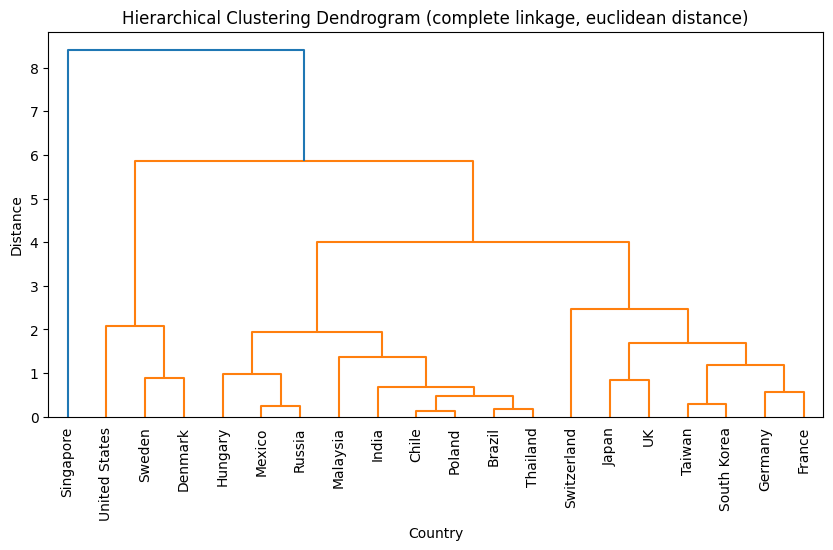

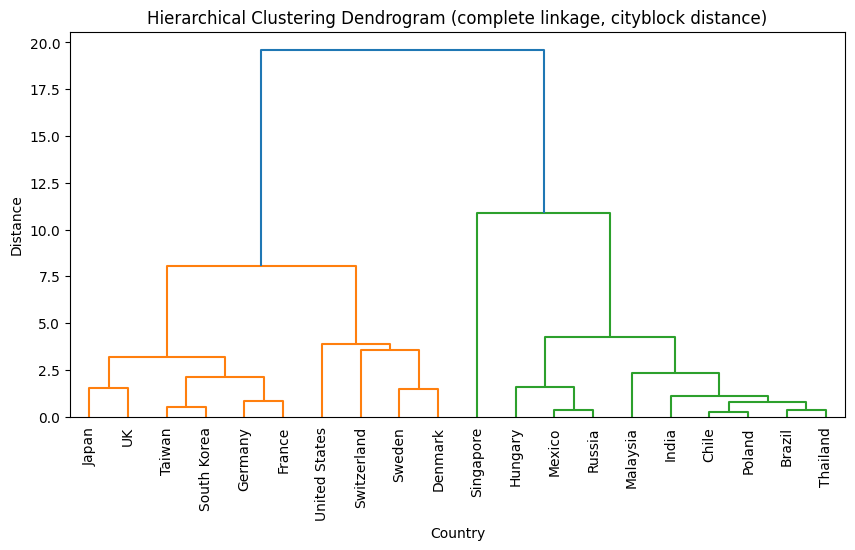

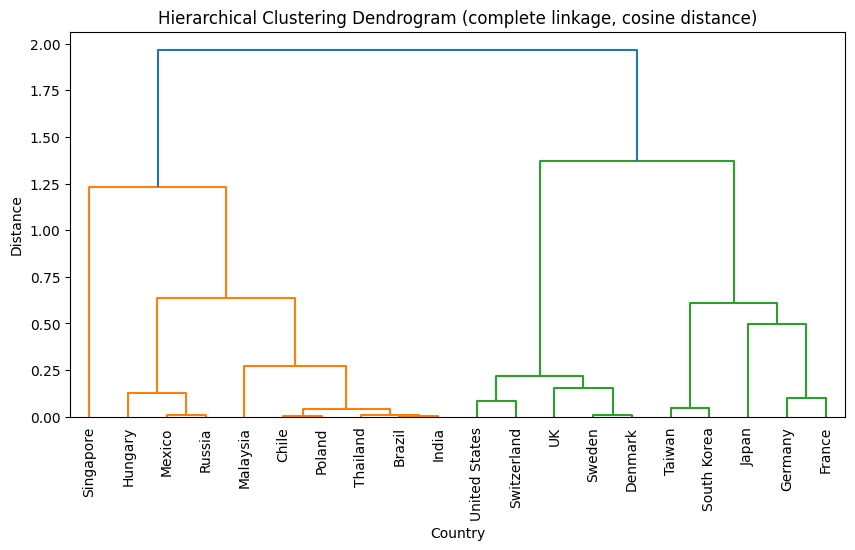

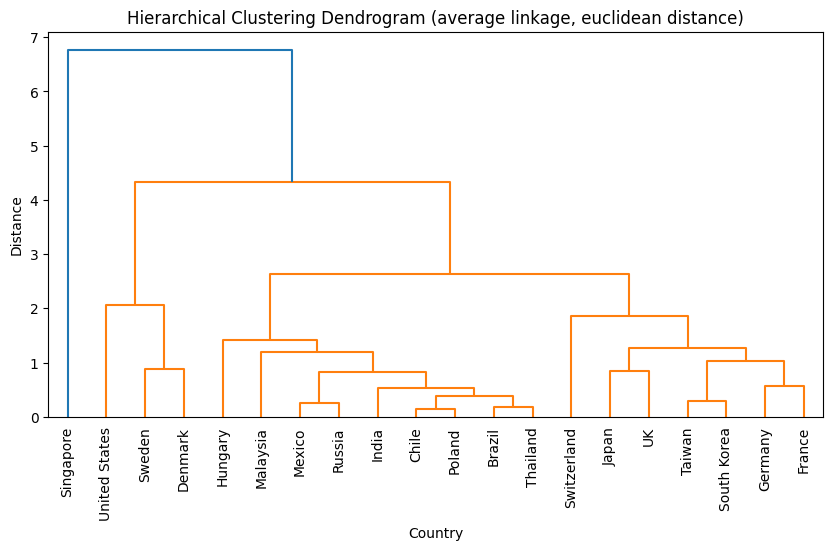

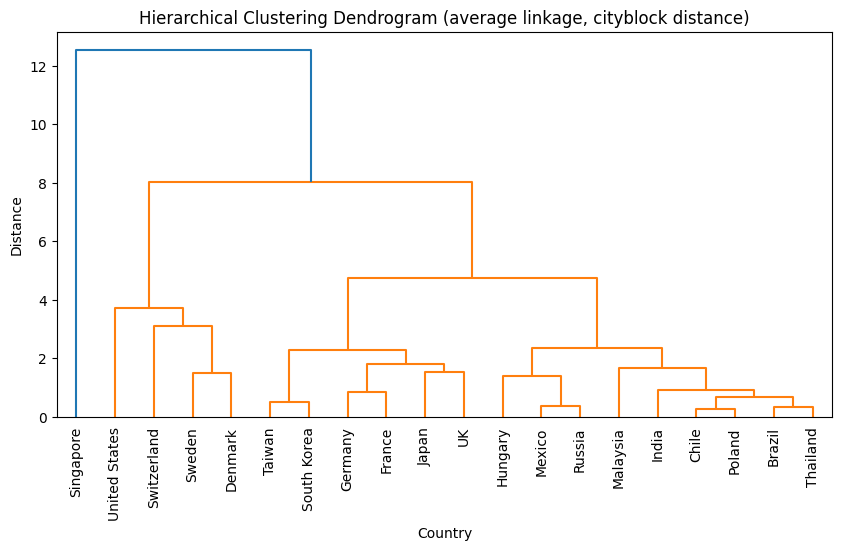

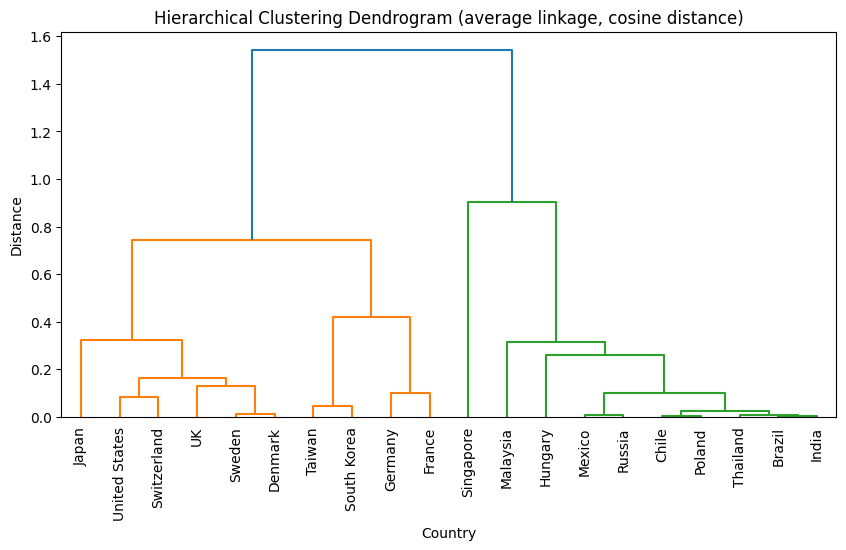

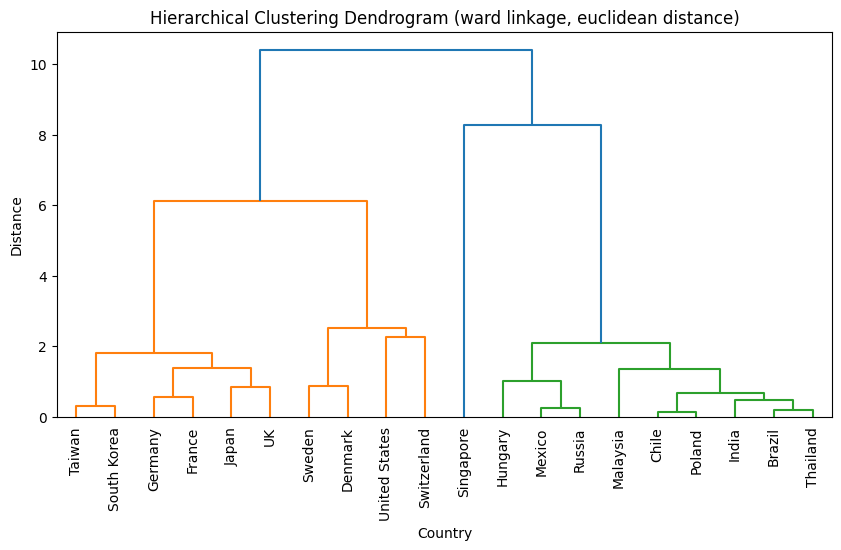

In [10]:
# Step 4: 执行分层聚类（选择不同的链接方法与距离度量）
linkage_methods = ['single', 'complete', 'average', 'ward']  # 定义不同的链接方法
distance_metrics = ['euclidean', 'cityblock', 'cosine']  # 定义不同的距离度量
dendrograms = {}

# 通过不同的距离度量和链接方法来进行分层聚类
for method in linkage_methods:
    for metric in distance_metrics:
        # 仅在使用 'ward' 方法时，确保使用 'euclidean' 距离度量
        if method == 'ward' and metric != 'euclidean':
            continue  # 跳过不符合条件的组合
        
        # 执行聚类
        Z = linkage(data_scaled, method=method, metric=metric)
        dendrograms[(method, metric)] = Z
        
        # 绘制树状图
        plt.figure(figsize=(10, 5))
        dendrogram(Z, labels=data['country'].values, leaf_rotation=90, leaf_font_size=10)
        plt.title(f"Hierarchical Clustering Dendrogram ({method} linkage, {metric} distance)")
        plt.xlabel("Country")
        plt.ylabel("Distance")
        plt.show()

- **定义链接方法和距离度量**：使用四种不同的链接方法（`single`, `complete`, `average`, `ward`）和三种距离度量（`euclidean`, `cityblock`, `cosine`）来进行分层聚类。

- 循环进行聚类分析：
  - 根据每一种组合（链接方法和距离度量）执行层次聚类。
  - `linkage()` 函数用于计算层次聚类的链接矩阵（`Z`），数据、方法和距离度量作为参数。
  - 绘制每个组合的树状图，`dendrogram()` 函数用于生成树状图。

## 5. 根据聚类结果切割树状图，选择一个合理的阈值形成簇

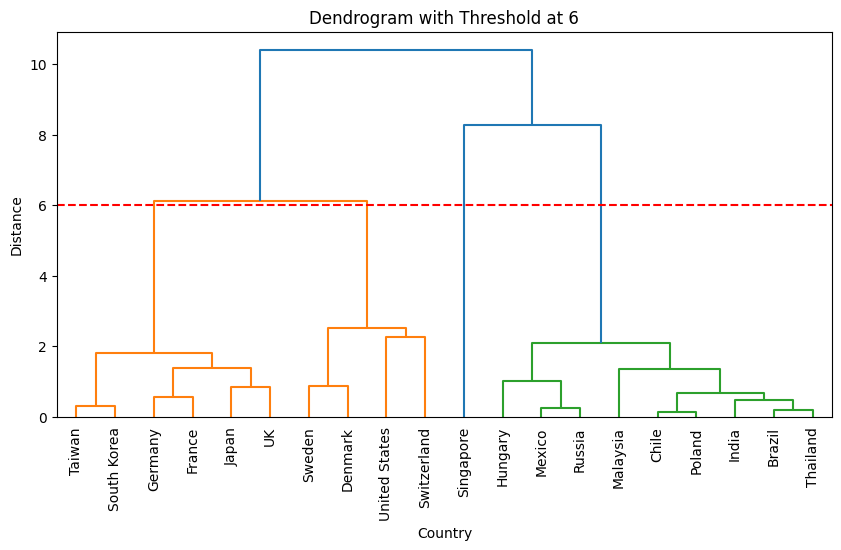

In [11]:
# Step 5: 根据聚类结果切割树状图，选择一个合理的阈值形成簇
# 使用动态阈值，可以根据树状图调整阈值
def plot_dendrogram_with_threshold(Z, threshold):
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=data['country'].values, leaf_rotation=90, leaf_font_size=10)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title(f"Dendrogram with Threshold at {threshold}")
    plt.xlabel("Country")
    plt.ylabel("Distance")
    plt.show()

# 例如：我先绘制一个阈值为6的树状图/后面可以更改....
Z_example = linkage(data_scaled, method='ward', metric='euclidean')
plot_dendrogram_with_threshold(Z_example, threshold=6)

**设置阈值切割树状图**：使用树状图切割聚类结果，`axhline()` 用于在树状图中绘制红色水平线，表示聚类的切割阈值。

## 6. 切割树状图并根据阈值进行聚类

In [12]:
# Step 6: 切割树状图并根据阈值进行聚类
threshold = 6  # 选择一个合理的阈值，可以根据树状图调整
clusters_results = {}
for metric in distance_metrics:
    for method in linkage_methods:
        # 仅在使用 'ward' 方法时，确保使用 'euclidean' 距离度量
        if method == 'ward' and metric != 'euclidean':
            continue  # 跳过不符合条件的组合
        
        # 执行聚类
        Z = linkage(data_scaled, method=method, metric=metric)
        clusters_results[(method, metric)] = fcluster(Z, t=threshold, criterion='distance')

# 将每种距离度量下的聚类结果添加到数据中
for (method, metric), clusters in clusters_results.items():
    data[f'Cluster_{method}_{metric}'] = clusters

- 切割聚类树：使用 

  ```
  fcluster()
  ```

   函数根据给定的阈值进行聚类，返回聚类标签（簇ID）。

  - `t=threshold` 参数定义了切割阈值，`criterion='distance'` 表示按距离切割树。

- **将聚类结果添加到数据中**

## 7. 手动分组：根据题目要求的实际情况分成两类

In [13]:
# Step 7: 手动分组：根据实际情况分成两类
transitional_countries = ['Brazil', 'Chile', 'Mexico', 'Russia', 'Poland', 'Hungary', 'Malaysia', 'Thailand', 'India']  
developed_countries = ['United States', 'Japan', 'Germany', 'Sweden', 'Switzerland', 'Denmark', 'UK', 'Singapore', 'Taiwan', 'South Korea', 'France']

# 添加一个列表示实际类别
data['Actual_Group'] = data['country'].apply(lambda x: 'Transitional' if x in transitional_countries else 'Developed')

**手动分组**：根据每个国家的实际情况，手动分为两类：“Transitional”（过渡国）和“Developed”（发达国）。`apply()` 函数根据国家列表为每个国家分配标签。

## 8. 显示聚类结果与实际分组的对比

In [14]:
# Step 8: 显示聚类结果与实际分组的对比
print("Hierarchical Clustering Results with Different Distance Metrics:")
print(data[['country', 'Actual_Group', 'Cluster_ward_euclidean']].head())

Hierarchical Clustering Results with Different Distance Metrics:
         country Actual_Group  Cluster_ward_euclidean
0  United States    Developed                       2
1          Japan    Developed                       1
2        Germany    Developed                       1
3         Sweden    Developed                       2
4    Switzerland    Developed                       2


**显示聚类与实际分组对比**：打印前几行数据，展示聚类结果与手动分组（`Actual_Group`）的对比。

## 9. 评估聚类结果与实际分组的匹配情况（使用交叉表和其他评估指标）

In [15]:
# Step 9: 评估聚类结果与实际分组的匹配情况（使用交叉表和其他评估指标）
# 交叉表对比
cross_tab = pd.crosstab(data['Actual_Group'], data['Cluster_ward_euclidean'])
print("\nCross Tabulation between Actual Group and Cluster (Ward-Euclidean):")
print(cross_tab)


Cross Tabulation between Actual Group and Cluster (Ward-Euclidean):
Cluster_ward_euclidean  1  2  3  4
Actual_Group                      
Developed               6  4  0  1
Transitional            0  0  9  0


- **交叉表**：使用 `pd.crosstab()` 生成交叉表，展示实际分组与聚类结果之间的匹配程度。

## 10. 计算并输出评估指标（ARI, NMI, Silhouette Score）

In [16]:
# Step 10: 计算并输出评估指标（ARI, NMI, Silhouette Score）
metrics = []
for method in linkage_methods:
    for metric in distance_metrics:
        # 仅在使用 'ward' 方法时，确保使用 'euclidean' 距离度量
        if method == 'ward' and metric != 'euclidean':
            continue  # 跳过不符合条件的组合

        # 获取聚类结果
        clusters = clusters_results[(method, metric)]

        # 计算 Adjusted Rand Index (ARI)
        ari = adjusted_rand_score(data['Actual_Group'], clusters)

        # 计算 Normalized Mutual Information (NMI)
        nmi = normalized_mutual_info_score(data['Actual_Group'], clusters)

        # 计算 Silhouette Score，只在簇数大于1时计算
        if len(np.unique(clusters)) > 1:
            silhouette = silhouette_score(data_scaled, clusters)
        else:
            silhouette = -1  # 如果只有一个簇，Silhouette Score 不适用，设置为 -1

        metrics.append({
            'Linkage Method': method,
            'Distance Metric': metric,
            'Adjusted Rand Index (ARI)': ari,
            'Normalized Mutual Information (NMI)': nmi,
            'Silhouette Score': silhouette
        })

# 输出评估结果
metrics_df = pd.DataFrame(metrics)
print("\nClustering Evaluation Metrics:")
print(metrics_df)


Clustering Evaluation Metrics:
  Linkage Method Distance Metric  Adjusted Rand Index (ARI)  \
0         single       euclidean                   0.000000   
1         single       cityblock                  -0.018330   
2         single          cosine                   0.000000   
3       complete       euclidean                  -0.018330   
4       complete       cityblock                   0.635974   
5       complete          cosine                   0.000000   
6        average       euclidean                  -0.018330   
7        average       cityblock                   0.080207   
8        average          cosine                   0.000000   
9           ward       euclidean                   0.635974   

   Normalized Mutual Information (NMI)  Silhouette Score  
0                             0.000000         -1.000000  
1                             0.069848          0.591834  
2                             0.000000         -1.000000  
3                             0.069848

+ 评估聚类效果：计算并输出聚类的评估指标：

    - **ARI**：调整后的兰德指数，用于衡量聚类与实际标签之间的一致性。
    - **NMI**：标准化互信息，衡量聚类与实际标签之间的相关性。
    - **Silhouette Score**：轮廓系数，用于评估聚类的质量。

## 11. 聚类结果可视化（PCA降维后绘制聚类结果）

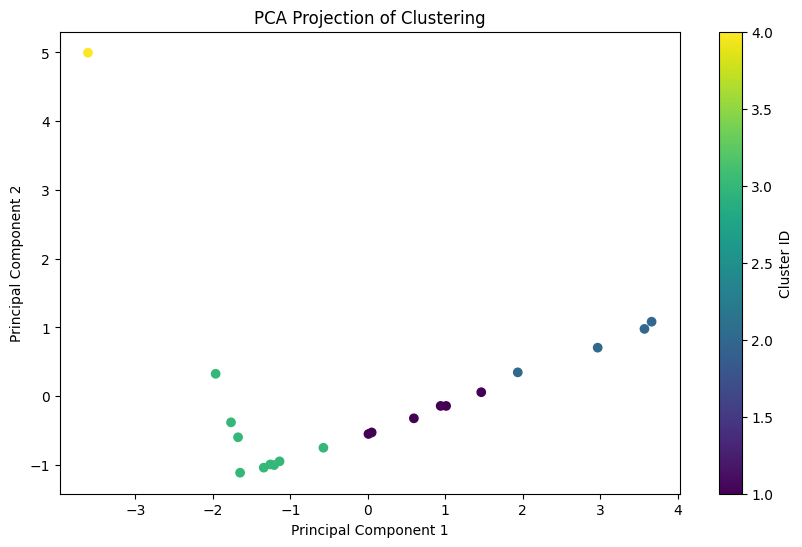

In [17]:
# Step 11: 聚类结果可视化（PCA降维后绘制聚类结果）
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=data['Cluster_ward_euclidean'], cmap='viridis', marker='o')
plt.title('PCA Projection of Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

- **PCA降维**：将高维数据降至2维，并通过 `scatter()` 绘制散点图。颜色表示聚类标签。
- **可视化**：通过PCA可视化聚类结果，帮助更直观地理解聚类的分布。

## 12. 显示完整的数据框

In [18]:
display(data)

,ID,country,call,movecall,fee,computer,mips,net,Cluster_single_euclidean,Cluster_complete_euclidean,Cluster_average_euclidean,Cluster_ward_euclidean,Cluster_single_cityblock,Cluster_complete_cityblock,Cluster_average_cityblock,Cluster_single_cosine,Cluster_complete_cosine,Cluster_average_cosine,Actual_Group
0,1,United States,631.6,161.90,0.36,403,26073.00,35.34,1,1,1,2,1,2,1,1,1,1,Developed
1,2,Japan,498.4,143.20,3.57,176,10223.00,6.26,1,1,1,1,1,1,2,1,1,1,Developed
2,3,Germany,557.6,70.60,2.18,199,11571.00,9.48,1,1,1,1,1,1,2,1,1,1,Developed
3,4,Sweden,684.1,281.80,1.40,286,16660.00,29.39,1,1,1,2,1,2,1,1,1,1,Developed
4,5,Switzerland,644.0,93.50,1.98,234,13621.00,22.68,1,1,1,2,1,2,1,1,1,1,Developed
5,6,Denmark,620.3,248.60,2.56,296,17210.00,21.84,1,1,1,2,1,2,1,1,1,1,Developed
6,7,Singapore,147.5,2.50,284.00,13578,13.49,3.24,1,2,2,4,2,4,3,1,1,1,Developed
7,8,Taiwan,469.4,56.10,3.68,119,6911.00,1.72,1,1,1,1,1,1,2,1,1,1,Developed
8,9,South Korea,434.5,73.00,3.36,99,5795.00,1.68,1,1,1,1,1,1,2,1,1,1,Developed
9,10,Brazil,81.9,16.30,3.02,19,876.00,0.52,1,1,1,3,1,3,2,1,1,1,Transitional


## 结果分析

### 1. **聚类与实际分组对比**
根据 `Cluster_ward_euclidean` 的聚类结果和实际分组的交叉表：

| **Actual Group** | **Cluster 1** | **Cluster 2** | **Cluster 3** | **Cluster 4** |
|------------------|---------------|---------------|---------------|---------------|
| Developed        | 6             | 4             | 0             | 1             |
| Transitional     | 0             | 0             | 9             | 0             |

### 2. **ARI**
各链接方法和距离度量的 ARI 值：

| **Linkage Method** | **Distance Metric** | **ARI**   |
|--------------------|---------------------|-----------|
| single             | euclidean           | 0.000000  |
| single             | cityblock           | -0.018330 |
| single             | cosine              | 0.000000  |
| complete           | euclidean           | -0.018330 |
| complete           | cityblock           | 0.635974  |
| complete           | cosine              | 0.000000  |
| average            | euclidean           | -0.018330 |
| average            | cityblock           | 0.080207  |
| average            | cosine              | 0.000000  |
| ward               | euclidean           | 0.635974  |

### 3. **NMI**
各链接方法和距离度量的 NMI 值：

| **Linkage Method** | **Distance Metric** | **NMI**    |
|--------------------|---------------------|-----------|
| single             | euclidean           | 0.000000  |
| single             | cityblock           | 0.069848  |
| single             | cosine              | 0.000000  |
| complete           | euclidean           | 0.069848  |
| complete           | cityblock           | 0.731933  |
| complete           | cosine              | 0.000000  |
| average            | euclidean           | 0.069848  |
| average            | cityblock           | 0.266623  |
| average            | cosine              | 0.000000  |
| ward               | euclidean           | 0.731933  |

### 4. **轮廓系数**
各链接方法和距离度量的 Silhouette Score 值：

| **Linkage Method** | **Distance Metric** | **Silhouette Score** |
|--------------------|---------------------|----------------------|
| single             | euclidean           | -1.000000            |
| single             | cityblock           | 0.591834             |
| single             | cosine              | -1.000000            |
| complete           | euclidean           | 0.591834             |
| complete           | cityblock           | 0.498336             |
| complete           | cosine              | -1.000000            |
| average            | euclidean           | 0.591834             |
| average            | cityblock           | 0.495582             |
| average            | cosine              | -1.000000            |
| ward               | euclidean           | 0.498336             |

---

### 5. **聚类结果的可视化与评估总结**
- **最佳聚类方法**：`ward` 和 `complete` 方法结合 `euclidean` 距离度量，表现最佳，尤其在 ARI 和 NMI 方面均有较高分数。
- **ARI**：`ward` 和 `complete` 方法显示了较好的聚类一致性（ARI = 0.635974），而 `single` 和 `average` 方法的结果较差。
- **NMI**：`ward` 和 `complete` 方法的 NMI 值为 0.731933，显示出较好的聚类相关性。
- **轮廓系数**：大多数方法的轮廓系数较低，尤其是 `single` 和 `cosine`，这表明这些方法的聚类质量较差。`ward` 和 `complete` 方法的轮廓系数较为中等，反映了较为合理的聚类质量。

总结，`ward` 和 `complete` 方法能得到较好的聚类效果。

## 完整代码

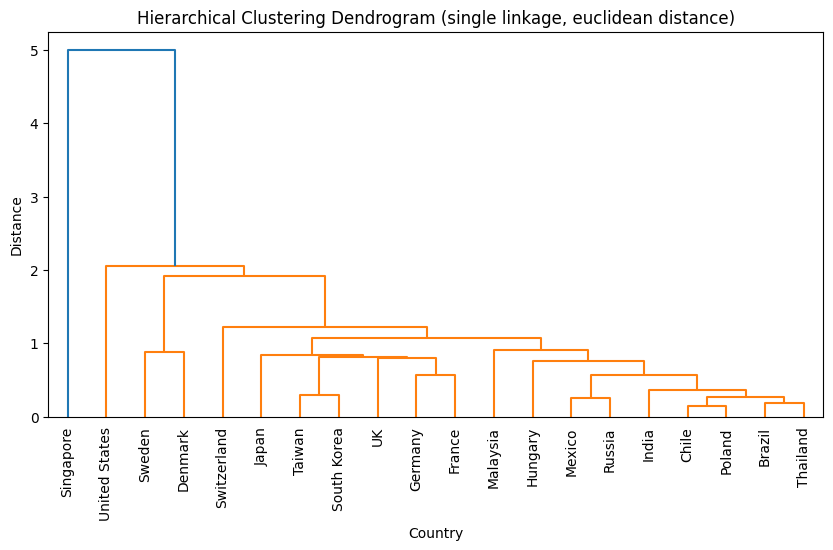

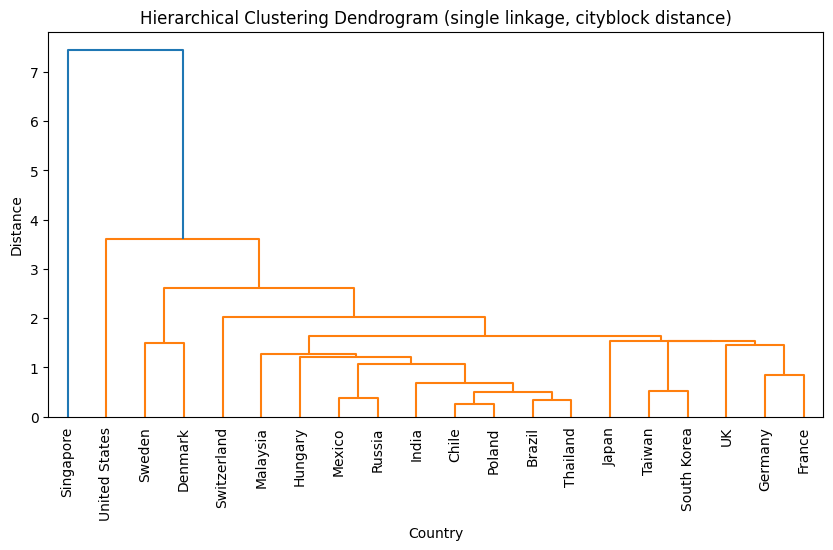

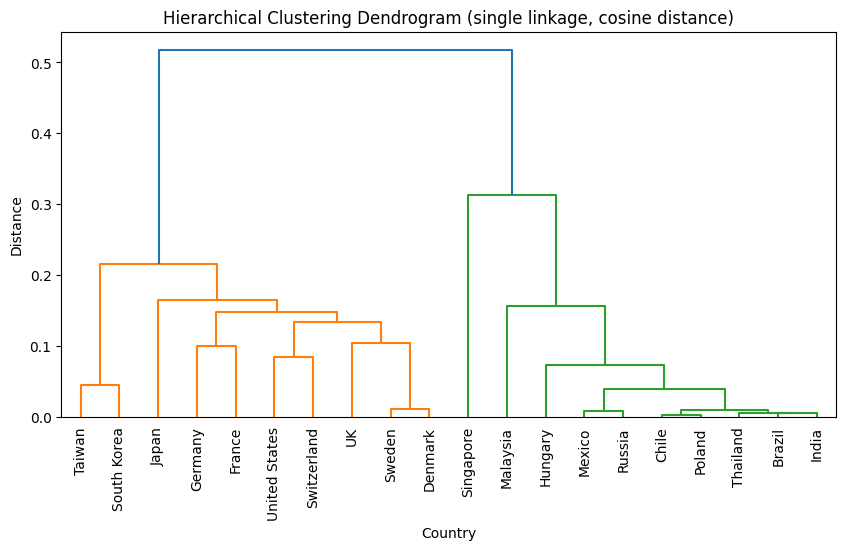

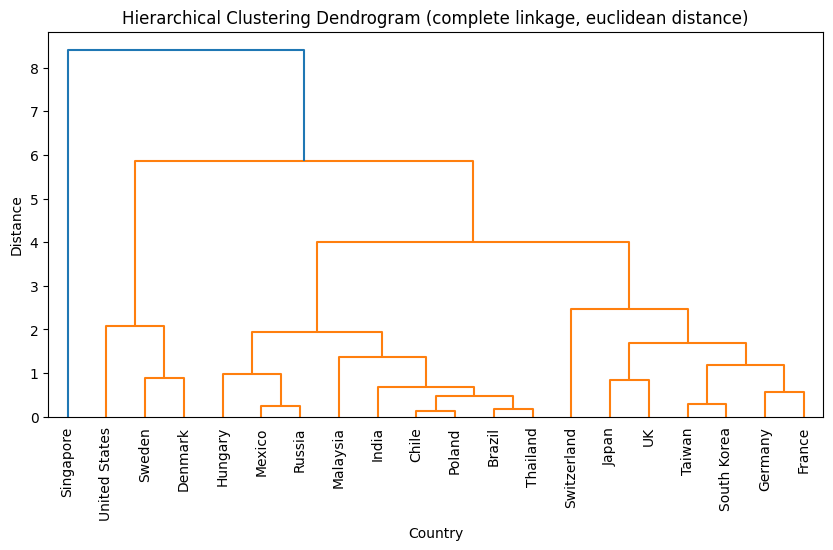

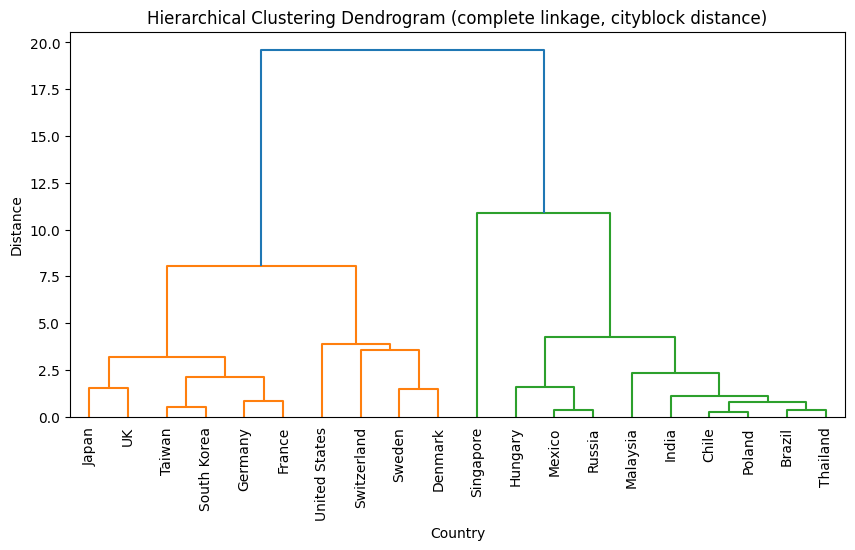

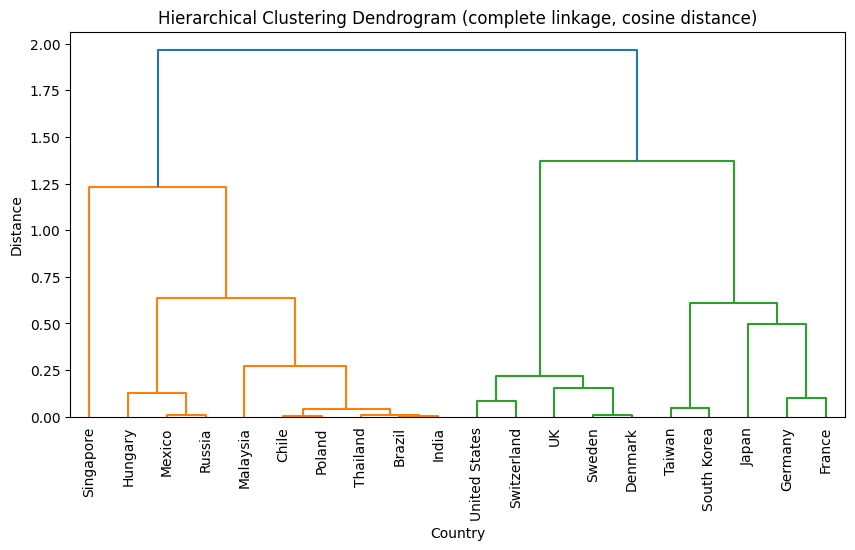

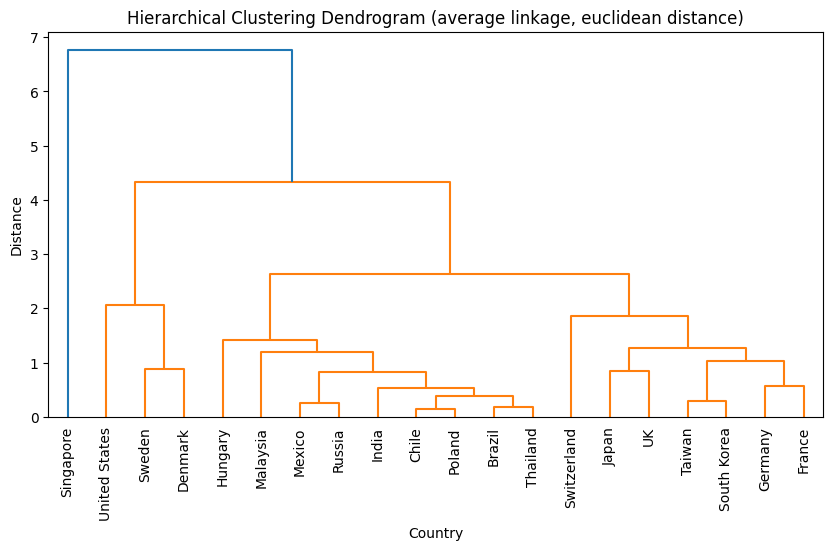

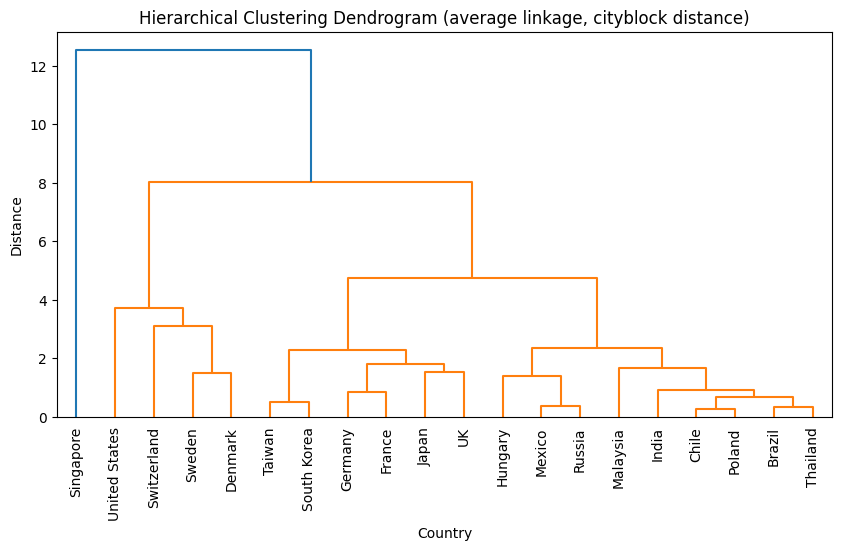

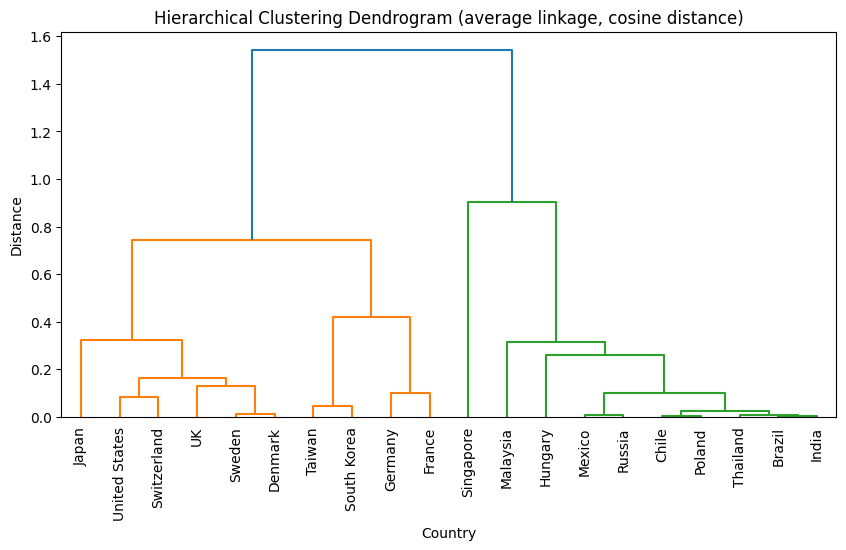

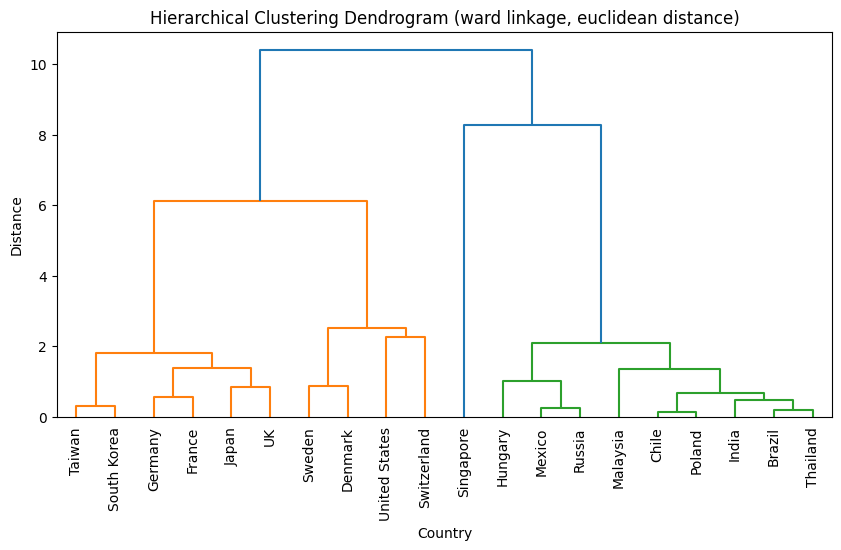

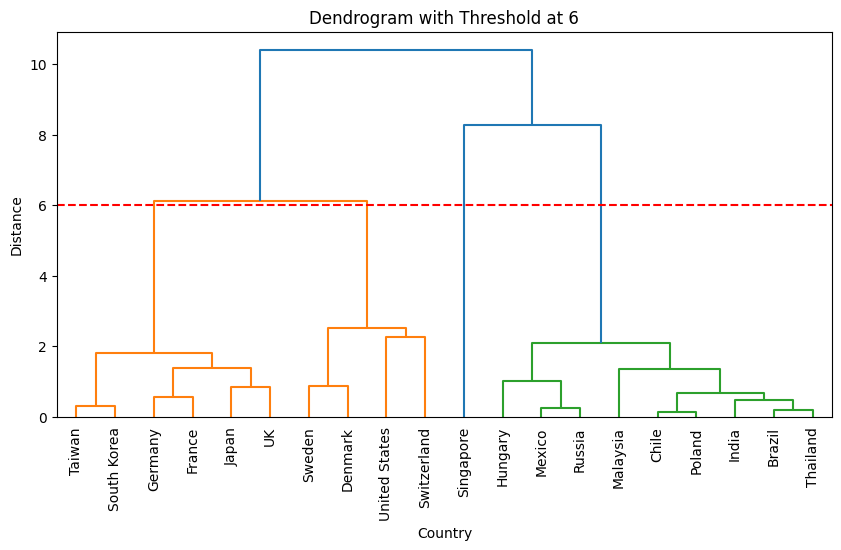

Hierarchical Clustering Results with Different Distance Metrics:
         country Actual_Group  Cluster_ward_euclidean
0  United States    Developed                       2
1          Japan    Developed                       1
2        Germany    Developed                       1
3         Sweden    Developed                       2
4    Switzerland    Developed                       2

Cross Tabulation between Actual Group and Cluster (Ward-Euclidean):
Cluster_ward_euclidean  1  2  3  4
Actual_Group                      
Developed               6  4  0  1
Transitional            0  0  9  0

Clustering Evaluation Metrics:
  Linkage Method Distance Metric  Adjusted Rand Index (ARI)  \
0         single       euclidean                   0.000000   
1         single       cityblock                  -0.018330   
2         single          cosine                   0.000000   
3       complete       euclidean                  -0.018330   
4       complete       cityblock                   0.63

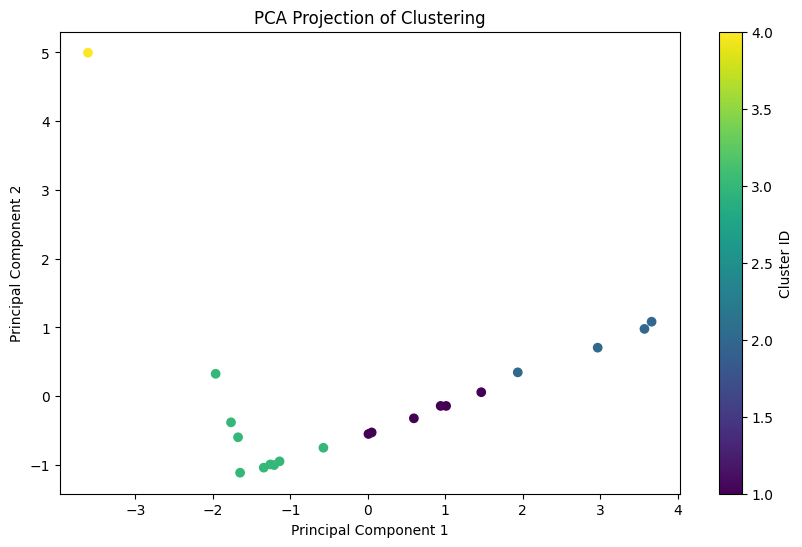

,ID,country,call,movecall,fee,computer,mips,net,Cluster_single_euclidean,Cluster_complete_euclidean,Cluster_average_euclidean,Cluster_ward_euclidean,Cluster_single_cityblock,Cluster_complete_cityblock,Cluster_average_cityblock,Cluster_single_cosine,Cluster_complete_cosine,Cluster_average_cosine,Actual_Group
0,1,United States,631.6,161.90,0.36,403,26073.00,35.34,1,1,1,2,1,2,1,1,1,1,Developed
1,2,Japan,498.4,143.20,3.57,176,10223.00,6.26,1,1,1,1,1,1,2,1,1,1,Developed
2,3,Germany,557.6,70.60,2.18,199,11571.00,9.48,1,1,1,1,1,1,2,1,1,1,Developed
3,4,Sweden,684.1,281.80,1.40,286,16660.00,29.39,1,1,1,2,1,2,1,1,1,1,Developed
4,5,Switzerland,644.0,93.50,1.98,234,13621.00,22.68,1,1,1,2,1,2,1,1,1,1,Developed
5,6,Denmark,620.3,248.60,2.56,296,17210.00,21.84,1,1,1,2,1,2,1,1,1,1,Developed
6,7,Singapore,147.5,2.50,284.00,13578,13.49,3.24,1,2,2,4,2,4,3,1,1,1,Developed
7,8,Taiwan,469.4,56.10,3.68,119,6911.00,1.72,1,1,1,1,1,1,2,1,1,1,Developed
8,9,South Korea,434.5,73.00,3.36,99,5795.00,1.68,1,1,1,1,1,1,2,1,1,1,Developed
9,10,Brazil,81.9,16.30,3.02,19,876.00,0.52,1,1,1,3,1,3,2,1,1,1,Transitional


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Step 1: 读取数据并预处理
file_path = '/home/aistudio/dataset/01-True/country_translate_english.csv'  
data = pd.read_csv(file_path)

# Step 2: 处理缺失值
# 用 'net' 列的中位数填充缺失值
data['net'] = data['net'].fillna(data['net'].median())

# Step 3: 选择数值列并标准化数据
data_values = data.iloc[:, 2:].values  # 选择数值列进行聚类
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_values)

# Step 4: 执行分层聚类（选择不同的链接方法与距离度量）
linkage_methods = ['single', 'complete', 'average', 'ward']  # 定义不同的链接方法
distance_metrics = ['euclidean', 'cityblock', 'cosine']  # 定义不同的距离度量
dendrograms = {}

# 通过不同的距离度量和链接方法来进行分层聚类
for method in linkage_methods:
    for metric in distance_metrics:
        # 仅在使用 'ward' 方法时，确保使用 'euclidean' 距离度量
        if method == 'ward' and metric != 'euclidean':
            continue  # 跳过不符合条件的组合
        
        # 执行聚类
        Z = linkage(data_scaled, method=method, metric=metric)
        dendrograms[(method, metric)] = Z
        
        # 绘制树状图
        plt.figure(figsize=(10, 5))
        dendrogram(Z, labels=data['country'].values, leaf_rotation=90, leaf_font_size=10)
        plt.title(f"Hierarchical Clustering Dendrogram ({method} linkage, {metric} distance)")
        plt.xlabel("Country")
        plt.ylabel("Distance")
        plt.show()

# Step 5: 根据聚类结果切割树状图，选择一个合理的阈值形成簇
# 使用动态阈值，可以根据树状图调整阈值
def plot_dendrogram_with_threshold(Z, threshold):
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=data['country'].values, leaf_rotation=90, leaf_font_size=10)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title(f"Dendrogram with Threshold at {threshold}")
    plt.xlabel("Country")
    plt.ylabel("Distance")
    plt.show()

# 例如：我先绘制一个阈值为6的树状图/后面可以更改....
Z_example = linkage(data_scaled, method='ward', metric='euclidean')
plot_dendrogram_with_threshold(Z_example, threshold=6)

# Step 6: 切割树状图并根据阈值进行聚类
threshold = 6  # 选择一个合理的阈值，可以根据树状图调整
clusters_results = {}
for metric in distance_metrics:
    for method in linkage_methods:
        # 仅在使用 'ward' 方法时，确保使用 'euclidean' 距离度量
        if method == 'ward' and metric != 'euclidean':
            continue  # 跳过不符合条件的组合
        
        # 执行聚类
        Z = linkage(data_scaled, method=method, metric=metric)
        clusters_results[(method, metric)] = fcluster(Z, t=threshold, criterion='distance')

# 将每种距离度量下的聚类结果添加到数据中
for (method, metric), clusters in clusters_results.items():
    data[f'Cluster_{method}_{metric}'] = clusters

# Step 7: 手动分组：根据实际情况分成两类
transitional_countries = ['Brazil', 'Chile', 'Mexico', 'Russia', 'Poland', 'Hungary', 'Malaysia', 'Thailand', 'India']  
developed_countries = ['United States', 'Japan', 'Germany', 'Sweden', 'Switzerland', 'Denmark', 'UK', 'Singapore', 'Taiwan', 'South Korea', 'France']

# 添加一个列表示实际类别
data['Actual_Group'] = data['country'].apply(lambda x: 'Transitional' if x in transitional_countries else 'Developed')

# Step 8: 显示聚类结果与实际分组的对比
print("Hierarchical Clustering Results with Different Distance Metrics:")
print(data[['country', 'Actual_Group', 'Cluster_ward_euclidean']].head())

# Step 9: 评估聚类结果与实际分组的匹配情况（使用交叉表和其他评估指标）
# 交叉表对比
cross_tab = pd.crosstab(data['Actual_Group'], data['Cluster_ward_euclidean'])
print("\nCross Tabulation between Actual Group and Cluster (Ward-Euclidean):")
print(cross_tab)

# Step 10: 计算并输出评估指标（ARI, NMI, Silhouette Score）
metrics = []
for method in linkage_methods:
    for metric in distance_metrics:
        # 仅在使用 'ward' 方法时，确保使用 'euclidean' 距离度量
        if method == 'ward' and metric != 'euclidean':
            continue  # 跳过不符合条件的组合

        # 获取聚类结果
        clusters = clusters_results[(method, metric)]

        # 计算 Adjusted Rand Index (ARI)
        ari = adjusted_rand_score(data['Actual_Group'], clusters)

        # 计算 Normalized Mutual Information (NMI)
        nmi = normalized_mutual_info_score(data['Actual_Group'], clusters)

        # 计算 Silhouette Score，只在簇数大于1时计算
        if len(np.unique(clusters)) > 1:
            silhouette = silhouette_score(data_scaled, clusters)
        else:
            silhouette = -1  # 如果只有一个簇，Silhouette Score 不适用，设置为 -1

        metrics.append({
            'Linkage Method': method,
            'Distance Metric': metric,
            'Adjusted Rand Index (ARI)': ari,
            'Normalized Mutual Information (NMI)': nmi,
            'Silhouette Score': silhouette
        })

# 输出评估结果
metrics_df = pd.DataFrame(metrics)
print("\nClustering Evaluation Metrics:")
print(metrics_df)

# Step 11: 聚类结果可视化（PCA降维后绘制聚类结果）
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=data['Cluster_ward_euclidean'], cmap='viridis', marker='o')
plt.title('PCA Projection of Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

# 显示完整的数据框
display(data)
